<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_Identification_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Téléchargement des données

In [2]:
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip?raw=true"
!unzip Bitcoin_complet.zip

--2021-04-29 16:59:48--  https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip [following]
--2021-04-29 16:59:49--  https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip [following]
--2021-04-29 16:59:49--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/

In [3]:
df_data=pd.read_csv('Bitcoin_complet.csv')
df_data.shape

(2309, 780)

In [4]:
df_data.head()

,Dates,#Active_Adresses,Block Size,Block Time,FeeInReward,Price,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,2015-01-01,114998.0,187402.0,8.727,0.195,315.626,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,129854868.0,21.241,18681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,184462.0,265055.0,8.727,0.286,314.346,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,212156964.0,21.197,9385.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,216194.0,295066.0,8.889,0.291,303.591,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,235281521.0,21.127,8342.5,171884.666667,249174.333333,8.781000,0.257333,311.187667,0.044533,2810.000000,123941.666667,7.354667,3.286958e+17,4.212884e+09,0.031133,100.406000,4.064096e+10,73455.333333,3.894000,1.924311e+08,21.188333,12136.166667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,209509.0,282161.0,8.372,0.504,274.820,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e+10,85522.0,3.586,271649082.0,21.157,7300.0,203388.333333,280760.666667,8.662667,0.360333,297.585667,0.053500,3192.000000,140320.000000,8.209000,3.317068e+17,4.037611e+09,0.029767,108.839667,4.064096e+10,82236.333333,3.739667,2.396959e+08,21.160333,8342.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,208147.0,360878.0,9.231,0.412,272.076,0.0459,3222.0,161359.0,9.439,3.350929e+17,3.705753e+09,0.0272,90.598,4.064096e+10,95429.0,3.180,283038295.0,21.155,23092.0,211283.333333,312701.666667,8.830667,0.402333,283.495667,0.053133,3306.666667,148994.000000,8.813667,3.333361e+17,3.848725e+09,0.028367,97.407333,4.064096e+10,87672.000000,3.487000,2.633230e+08,21.146333,12911.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Préparation des jeux de données

In [5]:
# Déplace la colonne Prix au début
col_prix = df_data.pop('Price')
df_data.insert(1,'Price',col_prix)
df_data.head()

,Dates,Price,#Active_Adresses,Block Size,Block Time,FeeInReward,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,2015-01-01,315.626,114998.0,187402.0,8.727,0.195,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,129854868.0,21.241,18681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,314.346,184462.0,265055.0,8.727,0.286,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,212156964.0,21.197,9385.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,303.591,216194.0,295066.0,8.889,0.291,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,235281521.0,21.127,8342.5,171884.666667,249174.333333,8.781000,0.257333,311.187667,0.044533,2810.000000,123941.666667,7.354667,3.286958e+17,4.212884e+09,0.031133,100.406000,4.064096e+10,73455.333333,3.894000,1.924311e+08,21.188333,12136.166667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,274.820,209509.0,282161.0,8.372,0.504,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e+10,85522.0,3.586,271649082.0,21.157,7300.0,203388.333333,280760.666667,8.662667,0.360333,297.585667,0.053500,3192.000000,140320.000000,8.209000,3.317068e+17,4.037611e+09,0.029767,108.839667,4.064096e+10,82236.333333,3.739667,2.396959e+08,21.160333,8342.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,272.076,208147.0,360878.0,9.231,0.412,0.0459,3222.0,161359.0,9.439,3.350929e+17,3.705753e+09,0.0272,90.598,4.064096e+10,95429.0,3.180,283038295.0,21.155,23092.0,211283.333333,312701.666667,8.830667,0.402333,283.495667,0.053133,3306.666667,148994.000000,8.813667,3.333361e+17,3.848725e+09,0.028367,97.407333,4.064096e+10,87672.000000,3.487000,2.633230e+08,21.146333,12911.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
X_raw = df_data.iloc[:,2:20]
X_raw.head()

,#Active_Adresses,Block Size,Block Time,FeeInReward,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets
0,114998.0,187402.0,8.727,0.195,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,129854868.0,21.241,18681.0
1,184462.0,265055.0,8.727,0.286,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,212156964.0,21.197,9385.0
2,216194.0,295066.0,8.889,0.291,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,235281521.0,21.127,8342.5
3,209509.0,282161.0,8.372,0.504,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e+10,85522.0,3.586,271649082.0,21.157,7300.0
4,208147.0,360878.0,9.231,0.412,0.0459,3222.0,161359.0,9.439,3.350929e+17,3.705753e+09,0.0272,90.598,4.064096e+10,95429.0,3.180,283038295.0,21.155,23092.0


In [7]:
y = df_data.iloc[:,1:2]
y.head()

,Price
0,315.626
1,314.346
2,303.591
3,274.820
4,272.076


# Identification des variables par Random Forest

**1. Sélection des indicateurs pour les prédictions sur 1 jour**

In [8]:
X = df_data
X = X.drop(columns=['Price','Dates'])
Xdrop = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(X)
Xdrop = pd.DataFrame(Xdrop)
Xdrop.columns =X.columns
X = Xdrop
X

,#Active_Adresses,Block Size,Block Time,FeeInReward,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,Block Size_sma7,Block Time_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,114998.0,187402.0,8.727,0.195,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,1.298549e+08,21.241,18681.0,568638.333333,718313.666667,8.996667,0.399333,999.189333,0.069233,1989.666667,320173.000000,6.595667,2.738239e+17,2.759515e+09,0.023700,21.981233,6.653303e+12,314527.000000,0.134333,1.233088e+08,15.635000,23921.333333,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
1,184462.0,265055.0,8.727,0.286,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,2.121570e+08,21.197,9385.0,568638.333333,718313.666667,8.996667,0.399333,999.189333,0.069233,1989.666667,320173.000000,6.595667,2.738239e+17,2.759515e+09,0.023700,21.981233,6.653303e+12,314527.000000,0.134333,1.233088e+08,15.635000,23921.333333,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
2,216194.0,295066.0,8.889,0.291,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,2.352815e+08,21.127,8342.5,171884.666667,249174.333333,8.781000,0.257333,311.187667,0.044533,2810.000000,123941.666667,7.354667,3.286958e+17,4.212884e+09,0.031133,100.406000,4.064096e+10,73455.333333,3.894000,1.924311e+08,21.188333,12136.166667,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
3,209509.0,282161.0,8.372,0.504,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e

**Choix du nombre d'arbres :**

In [42]:
# Informations sur les données
n = 2309              # Nombre d'observations
p = 778               # Nombre de variables

n_arbres_max = 25

n_arbres = np.linspace(1,n_arbres_max,10).astype(np.int32)
mtry = np.sqrt(p).astype(np.int32)
OOB_err = []

for i in n_arbres:
  print("#Arbres : %d" %i)
  clf = RandomForestRegressor(n_estimators=i, bootstrap=True, oob_score=True, max_samples = n, max_features = mtry, n_jobs=-1)
  clf.fit(X,tf.squeeze(np.asarray(y),1))
  OOB_err.append(1 - clf.oob_score_)

#Arbres : 1
#Arbres : 3


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 6


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 9


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 11


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 14


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 17


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 19
#Arbres : 22
#Arbres : 25


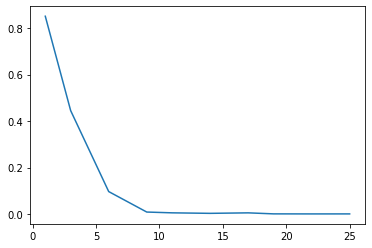

In [43]:
plt.plot(n_arbres,OOB_err)

On choisit n_arbres = 25

**Choix de la valeur de mtry (nombre de variables testées à chaque division)**

In [44]:
(np.sqrt(p)/2).astype(np.int32)

13

In [47]:
# Informations sur les données
n = 2309              # Nombre d'observations
p = 778               # Nombre de variables

n_arbres = 25
mtry_0 = (np.sqrt(p)/2).astype(np.int32)

m_try = np.linspace(mtry_0,778,10).astype(np.int32)

OOB_err = []

for i in m_try:
   print("mtry = %s" %i)
   clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=i, n_jobs=-1)
   clf.fit(X,tf.squeeze(np.asarray(y),1))
   OOB_err.append(1 - clf.oob_score_)

mtry = 13
mtry = 259
mtry = 506
mtry = 753
mtry = 1000


ValueError: ignored

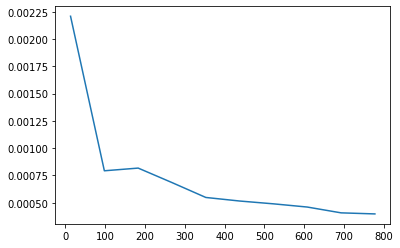

In [46]:
plt.plot(m_try,OOB_err)

On choisit mtry = 768

**Importance des variables - Pemière approche**

In [9]:
from sklearn.inspection import permutation_importance

# Informations sur les données
n = 102               # Nombre d'observations
p = 6033              # Nombre de variables
n_arbres = 25
m_try = 768

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
clf.fit(X,tf.squeeze(np.asarray(y),1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=768, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [97]:
col_sorted_by_importance=clf.feature_importances_.argsort()
feat_imp = pd.DataFrame({'cols':X.columns[col_sorted_by_importance],'imps':clf.feature_importances_[col_sorted_by_importance]})
feat_imp

,cols,imps
0,Median Transaction Value_sma14,5.242244e-10
1,Top100_wma30,8.233908e-10
2,#Active_Adresses_ema3,8.400678e-10
3,#From_Adresses_ema90,9.857681e-10
4,Transaction Value_trix14,9.881114e-10
...,...,...
773,Price_wma30,5.996396e-02
774,Capitalization_sma3,6.135274e-02
775,Price_trix7,6.871834e-02
776,Price_sma90,1.242402e-01


In [11]:
!pip install plotly_express --upgrade -q

In [98]:
import plotly_express as px
import plotly.offline as po

px.bar(feat_imp.sort_values(['imps'], ascending=False)[:30], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

**Importance des variables - Méthode des permutations**

Permutation importance is a technique where we shuffle the values of a single column and run the model to see how the scores get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

Let us see the feature importances for recall score on the test dataset.

In [29]:
import random

def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
#    baseline_metric=metric(y, clf.predict(X))
    baseline_metric=clf.score(X,y)
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
#            score=metric(y, clf.predict(X1))
            score = clf.score(X1,y)
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import progressbar

baseline, scores = PermImportance(X, tf.squeeze(np.asarray(y),1), clf, recall_score, num_iterations=10)

 99% (777 of 778) |##################### | Elapsed Time: 0:14:08 ETA:   0:00:01

In [ ]:
percent_changes={c:[] for c in X.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [ ]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[:25], 
    x='variable',y='value',labels={'variable':'column''value':'% change in recall'})

**Comparaison**

In [85]:
# Calcul des écarts-types et des moyennes
scores_std = {}
scores_mean = {}
for element in scores:
  scores_std[element] = np.std(scores[element])
  scores_mean[element] = np.mean(scores[element])

df_perm = pd.DataFrame.from_dict([scores_std, scores_mean]).transpose()
df_perm = df_perm.rename(columns={0:"std",1:"mean"})
df_perm = df_perm.sort_values(by=['mean'],ascending=False)
df_perm

,std,mean
Price_trix3,3.418003e-03,3.115846e-01
Price_sma90,5.185958e-04,1.608705e-02
Capitalization,1.036209e-04,7.683678e-03
Price_trix7,9.021455e-05,7.629464e-03
Capitalization_sma3,1.172928e-04,4.277620e-03
...,...,...
Price_rsi30,4.353026e-07,-8.440513e-07
Transaction Value_std90,2.786569e-07,-8.730437e-07
#Active_Adresses_roc3,8.070217e-07,-8.861007e-07
Top100_std7,6.430000e-07,-1.150262e-06


In [100]:
feature_imp_

,cols,imps
9,Difficulty_rsi3,1.807056e-09
8,Difficulty_trix30,1.722995e-09
7,Profiltability_sma14,1.630685e-09
6,Difficulty,1.601723e-09
5,Difficulty_std3,1.222653e-09
4,Transaction Value_trix14,9.881114e-10
3,#From_Adresses_ema90,9.857681e-10
2,#Active_Adresses_ema3,8.400678e-10
1,Top100_wma30,8.233908e-10
0,Median Transaction Value_sma14,5.242244e-10


In [123]:
feature_imp['cols'].values

array(['Price_trix3', 'Price_sma90', 'Price_trix7', 'Capitalization_sma3',
       'Price_wma30', 'Capitalization', 'Capitalization_trix14',
       'Capitalization_ema3', '#Active_Adresses_sma90', 'Price_trix90'],
      dtype=object)

In [128]:
feature_perm.index.values

array(['Price_trix3', 'Price_sma90', 'Capitalization', 'Price_trix7',
       'Capitalization_sma3', 'Price_wma30', 'Capitalization_ema3',
       'Capitalization_trix14', 'Capitalization_trix3',
       'Capitalization_sma30'], dtype=object)

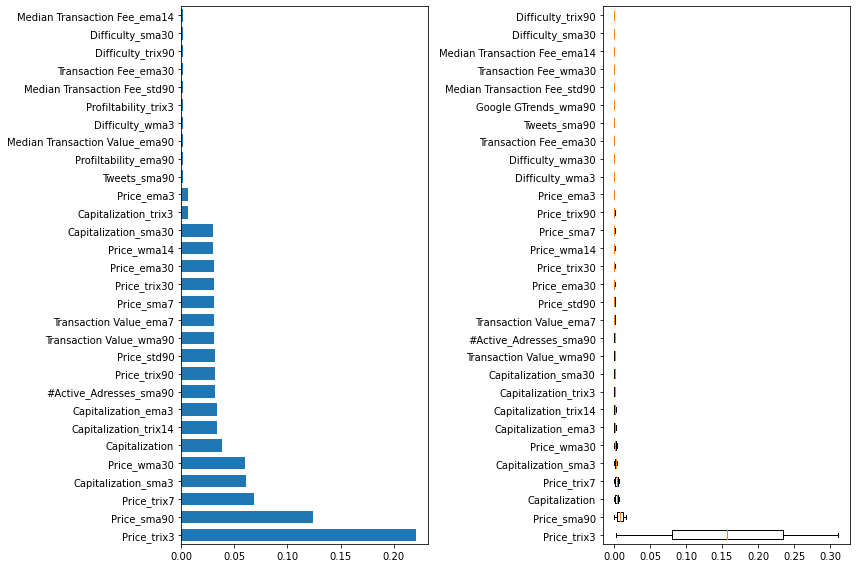

In [224]:
feature_perm = df_perm[0:30]
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp[0:30]

tree_indices = np.arange(0, len(feature_imp)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,feature_imp['imps'].values, height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_imp['cols'].values)
ax1.set_ylim((0, len(feature_imp)))

ax2.boxplot(feature_perm, vert=False,labels=feature_perm.index.values)
fig.tight_layout()
plt.show()

# Sélection des variables

**1. Elimination préliminaire dans les résultats de la première méthode**

In [213]:
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp.reset_index()
feature_imp


,index,cols,imps
0,777,Price_trix3,2.212619e-01
1,776,Price_sma90,1.242402e-01
2,775,Price_trix7,6.871834e-02
3,774,Capitalization_sma3,6.135274e-02
4,773,Price_wma30,5.996396e-02
...,...,...,...
773,4,Transaction Value_trix14,9.881114e-10
774,3,#From_Adresses_ema90,9.857681e-10
775,2,#Active_Adresses_ema3,8.400678e-10
776,1,Top100_wma30,8.233908e-10


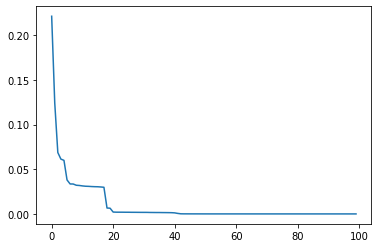

In [218]:
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp.reset_index()
feature_imp = feature_imp[0:100]
feature_imp = feature_imp.reset_index()

plt.plot(feature_imp.index.values,feature_imp['imps'])

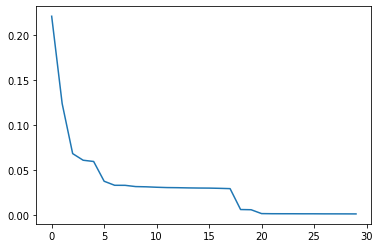

In [220]:
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp.reset_index()
feature_imp = feature_imp[0:30]
feature_imp = feature_imp.reset_index()

plt.plot(feature_imp.index.values,feature_imp['imps'])

**2. Elimination préliminaire dans les résultats de la deuxième méthode**

On commence par rechercher le minimum où la courbe se stabilise :

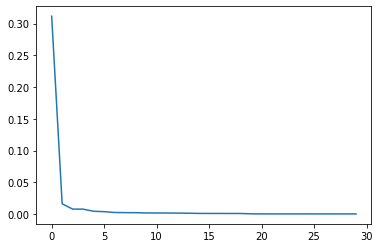

In [228]:
feature_perm = df_perm.sort_values(['mean'],ascending=False)
feature_perm = feature_perm.reset_index()
feature_perm = feature_perm[0:30]
feature_perm = feature_perm.reset_index()

plt.plot(feature_perm.index.values,feature_perm['mean'])

On affiche maintenant l'écart type de chaque variable :

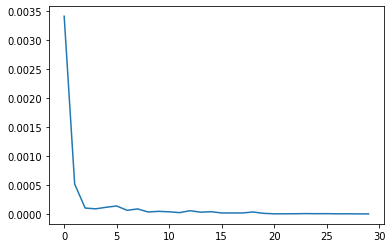

In [231]:
feature_perm = df_perm.sort_values(['mean'],ascending=False)
feature_perm = feature_perm.reset_index()
feature_perm = feature_perm[0:30]
feature_perm = feature_perm.reset_index()

plt.plot(feature_perm.index.values,feature_perm['std'])

On fit cette courbe avec un modèle CART (Classification and Regression Trees) :

In [ ]:
np.reshape(np.array(feature_perm.index.values),(-1,1))

In [271]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(criterion="mse")
regr.fit(np.reshape(np.array(feature_perm.index.values),(-1,1)),feature_perm['std'].values)
y_reg = regr.predict(np.reshape(np.array(feature_perm.index.values),(-1,1)))

In [272]:
import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Scatter(x=feature_perm.index.values,y=feature_perm['std'],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=feature_perm.index.values,y=y_reg,line=dict(color='red', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

In [275]:
index = []

for i in feature_perm.index.values.astype(np.int32):
  if feature_perm['std'].values[i] >= y_reg[i]:
    index.append(i)

In [276]:
index

[0, 1, 2, 3, 4, 5, 6, 7, 12]

In [288]:
variables_selected = feature_perm.iloc[index]
variables_selected = variables_selected.drop(columns='level_0')
variables_selected['index'].values

array(['Price_trix3', 'Price_sma90', 'Capitalization', 'Price_trix7',
       'Capitalization_sma3', 'Price_wma30', 'Capitalization_ema3',
       'Capitalization_trix14', 'Transaction Value_ema7'], dtype=object)

**Fusion des valeurs**

In [304]:
df_reduit1 = X[feature_imp['cols'].values]
df_reduit1

,Price_trix3,Price_sma90,Price_trix7,Capitalization_sma3,Price_wma30,Capitalization,Capitalization_trix14,Capitalization_ema3,#Active_Adresses_sma90,Price_trix90,Price_std90,Transaction Value_wma90,Transaction Value_ema7,Price_sma7,Price_trix30,Price_ema30,Price_wma14,Capitalization_sma30,Capitalization_trix3,Price_ema3,Tweets_sma90,Profiltability_ema90,Median Transaction Value_ema90,Difficulty_wma3,Profiltability_trix3,Median Transaction Fee_std90,Transaction Fee_ema30,Difficulty_trix90,Difficulty_sma30,Median Transaction Fee_ema14
0,200.277825,3756.922222,194.405452,2.759515e+09,6580.913978,4.287908e+09,2.745486e+09,2.809756e+09,214954.355556,227.818037,235.949638,2260.715751,1624.997316,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,2.697234e+09,206.643564,16873.077778,0.083256,62.208211,6.653303e+12,0.064423,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
1,200.277825,3756.922222,194.405452,2.759515e+09,6580.913978,4.272409e+09,2.745486e+09,2.809756e+09,214954.355556,227.818037,235.949638,2260.715751,1624.997316,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,2.697234e+09,206.643564,16873.077778,0.083256,62.208211,6.653303e+12,0.064423,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
2,311.187667,3756.922222,194.405452,4.212884e+09,6580.913978,4.078336e+09,2.745486e+09,4.212884e+09,214954.355556,227.818037,235.949638,2260.715751,1624.997316,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,4.212884e+09,311.187667,16873.077778,0.083256,62.208211,4.064096e+10,3.894000,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
3,279.365958,3756.922222,194.405452,4.037611e+09,6580.913978,3.762088e+09,2.745486e+09,3.987486e+09,214954.355556,227.818037,235.949638,2260.715751,1624.997316,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,3.818438e+09,293.003833,16873.077778,0.083256,62.208211,4.064096e+10,3.624500,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
4,270.146021,3756.922222,194.405452,3.848725e+09,6580.913978,3.705753e+09,2.745486e+09,3.846619e+09,214954.355556,227.818037,235.949638,2260.715751,1624.997316,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,3.684620e+09,282.539917,16873.077778,0.083256,62.208211,4.064096e+10,3.211500,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,50271.303907,50979.333333,50901.337908,9.914630e+11,57910.212903,9.324378e+11,9.912470e+11,9.793340e+11,961591.827778,62434.836781,8682.008227,314635.883028,393279.856300,55492.571429,56179.138213,57012.453918,56840.800000,1.078571e+12,9.395451e+11,52402.650954,102615.011111,0.328798,985.163582,2.358198e+13,0.353694,4.942729,33.181087,2.352358e+13,2.291706e+13,19.218453
2305,49740.497274,51177.522222,49601.041308,9.580243e+11,57415.361290,9.359612e+11,9.607802e+11,9.576476e+11,962155.572222,61902.581955,8449.914065,314131.834188,363921.142225,53888.571429,54896.934738,56565.005278,55723.133333,1.077339e+12,9.296716e+11,51239.825477,103004.633333,0.328846,977.904118,2.358198e+13,0.327466,4.889702,32.912952,2.356678e+13,2.297428e+13,18.330926
2306,49469.774482,51358.644444,48826.995139,9.321848e+11,56897.821505,9.281555e+11,9.363793e+11,9.429015e+11,961547.150000,61360.866494,8235.607880,314958.112576,357266.356669,52970.571429,53703.882136,56119.327518,54642.695238,1.075173e+12,9.246565e+11,50448.412738,103198.988889,0.327971,970.696841,2.358198e+13,0.288191,4.862619,32.336052,2.360734e+13,2.303149e+13,17.089069
2307,52472.951755,51591.411111,50518.733786,9.515974e+11,56603.595699,9.906756e+11,9.412604e+11,9.667886e+11,958993.638889,61053.046985,7975.720736,318773.740415,386522.517502,52486.714286,53274.310393,55918.080581,54104.533333,1.073865e+12,9.808259e+11,51724.206369,103807.033333,0.327246,976.395812,2.358198e+13,0.288023,4.867598,32.634178,2.364536e+13,2.308871e+13,17.112793


In [305]:
df_reduit2 = X[variables_selected['index'].values]
df_reduit2

,Price_trix3,Price_sma90,Capitalization,Price_trix7,Capitalization_sma3,Price_wma30,Capitalization_ema3,Capitalization_trix14,Transaction Value_ema7
0,200.277825,3756.922222,4.287908e+09,194.405452,2.759515e+09,6580.913978,2.809756e+09,2.745486e+09,1624.997316
1,200.277825,3756.922222,4.272409e+09,194.405452,2.759515e+09,6580.913978,2.809756e+09,2.745486e+09,1624.997316
2,311.187667,3756.922222,4.078336e+09,194.405452,4.212884e+09,6580.913978,4.212884e+09,2.745486e+09,1624.997316
3,279.365958,3756.922222,3.762088e+09,194.405452,4.037611e+09,6580.913978,3.987486e+09,2.745486e+09,1624.997316
4,270.146021,3756.922222,3.705753e+09,194.405452,3.848725e+09,6580.913978,3.846619e+09,2.745486e+09,1624.997316
...,...,...,...,...,...,...,...,...,...
2304,50271.303907,50979.333333,9.324378e+11,50901.337908,9.914630e+11,57910.212903,9.793340e+11,9.912470e+11,393279.856300
2305,49740.497274,51177.522222,9.359612e+11,49601.041308,9.580243e+11,57415.361290,9.576476e+11,9.607802e+11,363921.142225
2306,49469.774482,51358.644444,9.281555e+11,48826.995139,9.321848e+11,56897.821505,9.429015e+11,9.363793e+11,357266.356669
2307,52472.951755,51591.411111,9.906756e+11,50518.733786,9.515974e+11,56603.595699,9.667886e+11,9.412604e+11,386522.517502


In [306]:
df_merged=df_reduit2.merge(df_reduit1,how='outer')
df_merged

,Price_trix3,Price_sma90,Capitalization,Price_trix7,Capitalization_sma3,Price_wma30,Capitalization_ema3,Capitalization_trix14,Transaction Value_ema7,#Active_Adresses_sma90,Price_trix90,Price_std90,Transaction Value_wma90,Price_sma7,Price_trix30,Price_ema30,Price_wma14,Capitalization_sma30,Capitalization_trix3,Price_ema3,Tweets_sma90,Profiltability_ema90,Median Transaction Value_ema90,Difficulty_wma3,Profiltability_trix3,Median Transaction Fee_std90,Transaction Fee_ema30,Difficulty_trix90,Difficulty_sma30,Median Transaction Fee_ema14
0,200.277825,3756.922222,4.287908e+09,194.405452,2.759515e+09,6580.913978,2.809756e+09,2.745486e+09,1624.997316,214954.355556,227.818037,235.949638,2260.715751,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,2.697234e+09,206.643564,16873.077778,0.083256,62.208211,6.653303e+12,0.064423,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
1,200.277825,3756.922222,4.272409e+09,194.405452,2.759515e+09,6580.913978,2.809756e+09,2.745486e+09,1624.997316,214954.355556,227.818037,235.949638,2260.715751,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,2.697234e+09,206.643564,16873.077778,0.083256,62.208211,6.653303e+12,0.064423,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
2,311.187667,3756.922222,4.078336e+09,194.405452,4.212884e+09,6580.913978,4.212884e+09,2.745486e+09,1624.997316,214954.355556,227.818037,235.949638,2260.715751,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,4.212884e+09,311.187667,16873.077778,0.083256,62.208211,4.064096e+10,3.894000,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
3,279.365958,3756.922222,3.762088e+09,194.405452,4.037611e+09,6580.913978,3.987486e+09,2.745486e+09,1624.997316,214954.355556,227.818037,235.949638,2260.715751,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,3.818438e+09,293.003833,16873.077778,0.083256,62.208211,4.064096e+10,3.624500,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
4,270.146021,3756.922222,3.705753e+09,194.405452,3.848725e+09,6580.913978,3.846619e+09,2.745486e+09,1624.997316,214954.355556,227.818037,235.949638,2260.715751,1132.571429,217.233662,231.407259,219.074752,3.054578e+09,3.684620e+09,282.539917,16873.077778,0.083256,62.208211,4.064096e+10,3.211500,0.000904,0.034923,4.445110e+10,4.235289e+10,0.021972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,50271.303907,50979.333333,9.324378e+11,50901.337908,9.914630e+11,57910.212903,9.793340e+11,9.912470e+11,393279.856300,961591.827778,62434.836781,8682.008227,314635.883028,55492.571429,56179.138213,57012.453918,56840.800000,1.078571e+12,9.395451e+11,52402.650954,102615.011111,0.328798,985.163582,2.358198e+13,0.353694,4.942729,33.181087,2.352358e+13,2.291706e+13,19.218453
2305,49740.497274,51177.522222,9.359612e+11,49601.041308,9.580243e+11,57415.361290,9.576476e+11,9.607802e+11,363921.142225,962155.572222,61902.581955,8449.914065,314131.834188,53888.571429,54896.934738,56565.005278,55723.133333,1.077339e+12,9.296716e+11,51239.825477,103004.633333,0.328846,977.904118,2.358198e+13,0.327466,4.889702,32.912952,2.356678e+13,2.297428e+13,18.330926
2306,49469.774482,51358.644444,9.281555e+11,48826.995139,9.321848e+11,56897.821505,9.429015e+11,9.363793e+11,357266.356669,961547.150000,61360.866494,8235.607880,314958.112576,52970.571429,53703.882136,56119.327518,54642.695238,1.075173e+12,9.246565e+11,50448.412738,103198.988889,0.327971,970.696841,2.358198e+13,0.288191,4.862619,32.336052,2.360734e+13,2.303149e+13,17.089069
2307,52472.951755,51591.411111,9.906756e+11,50518.733786,9.515974e+11,56603.595699,9.667886e+11,9.412604e+11,386522.517502,958993.638889,61053.046985,7975.720736,318773.740415,52486.714286,53274.310393,55918.080581,54104.533333,1.073865e+12,9.808259e+11,51724.206369,103807.033333,0.327246,976.395812,2.358198e+13,0.288023,4.867598,32.634178,2.364536e+13,2.308871e+13,17.112793


**Elimination des variables corrélées**

In [284]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function for removing features with high vif
def drop_high_vif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

#function for listing vif values
def vif_values(X):
    add_constant(X)
    df=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return df

In [308]:
variables_selected_reduit = drop_high_vif(df_merged,thresh=10)
variables_selected_reduit

dropping 'Price_ema3' at index: 19
dropping 'Capitalization_ema3' at index: 6
dropping 'Price_trix3' at index: 0
dropping 'Price_wma14' at index: 14
dropping 'Capitalization_trix3' at index: 15
dropping 'Capitalization_trix14' at index: 5
dropping 'Price_ema30' at index: 12
dropping 'Price_trix7' at index: 2
dropping 'Price_sma7' at index: 9
dropping 'Difficulty_trix90' at index: 18
dropping 'Price_trix90' at index: 6
dropping 'Capitalization_sma3' at index: 2
dropping 'Capitalization_sma30' at index: 8
dropping 'Price_trix30' at index: 7
dropping 'Difficulty_wma3' at index: 10
dropping 'Price_wma30' at index: 2
dropping 'Transaction Fee_ema30' at index: 11
dropping 'Capitalization' at index: 1
dropping 'Transaction Value_wma90' at index: 4
dropping 'Price_sma90' at index: 0
dropping 'Median Transaction Value_ema90' at index: 5
Remaining variables:
Index(['Transaction Value_ema7', '#Active_Adresses_sma90', 'Price_std90',
       'Tweets_sma90', 'Profiltability_ema90', 'Profiltability_tr

,Transaction Value_ema7,#Active_Adresses_sma90,Price_std90,Tweets_sma90,Profiltability_ema90,Profiltability_trix3,Median Transaction Fee_std90,Difficulty_sma30,Median Transaction Fee_ema14
0,1624.997316,214954.355556,235.949638,16873.077778,0.083256,0.064423,0.000904,4.235289e+10,0.021972
1,1624.997316,214954.355556,235.949638,16873.077778,0.083256,0.064423,0.000904,4.235289e+10,0.021972
2,1624.997316,214954.355556,235.949638,16873.077778,0.083256,3.894000,0.000904,4.235289e+10,0.021972
3,1624.997316,214954.355556,235.949638,16873.077778,0.083256,3.624500,0.000904,4.235289e+10,0.021972
4,1624.997316,214954.355556,235.949638,16873.077778,0.083256,3.211500,0.000904,4.235289e+10,0.021972
...,...,...,...,...,...,...,...,...,...
2304,393279.856300,961591.827778,8682.008227,102615.011111,0.328798,0.353694,4.942729,2.291706e+13,19.218453
2305,363921.142225,962155.572222,8449.914065,103004.633333,0.328846,0.327466,4.889702,2.297428e+13,18.330926
2306,357266.356669,961547.150000,8235.607880,103198.988889,0.327971,0.288191,4.862619,2.303149e+13,17.089069
2307,386522.517502,958993.638889,7975.720736,103807.033333,0.327246,0.288023,4.867598,2.308871e+13,17.112793


# Dentogramme

**Gestion des variables colinéaires**

When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. First, we plot a heatmap of the correlated features:

In [137]:
feature_perm.index.values.tolist()

['Price_trix3',
 'Price_sma90',
 'Capitalization',
 'Price_trix7',
 'Capitalization_sma3',
 'Price_wma30',
 'Capitalization_ema3',
 'Capitalization_trix14',
 'Capitalization_trix3',
 'Capitalization_sma30',
 'Transaction Value_wma90',
 '#Active_Adresses_sma90',
 'Transaction Value_ema7',
 'Price_std90',
 'Price_ema30',
 'Price_trix30',
 'Price_wma14',
 'Price_sma7',
 'Price_trix90',
 'Price_ema3']

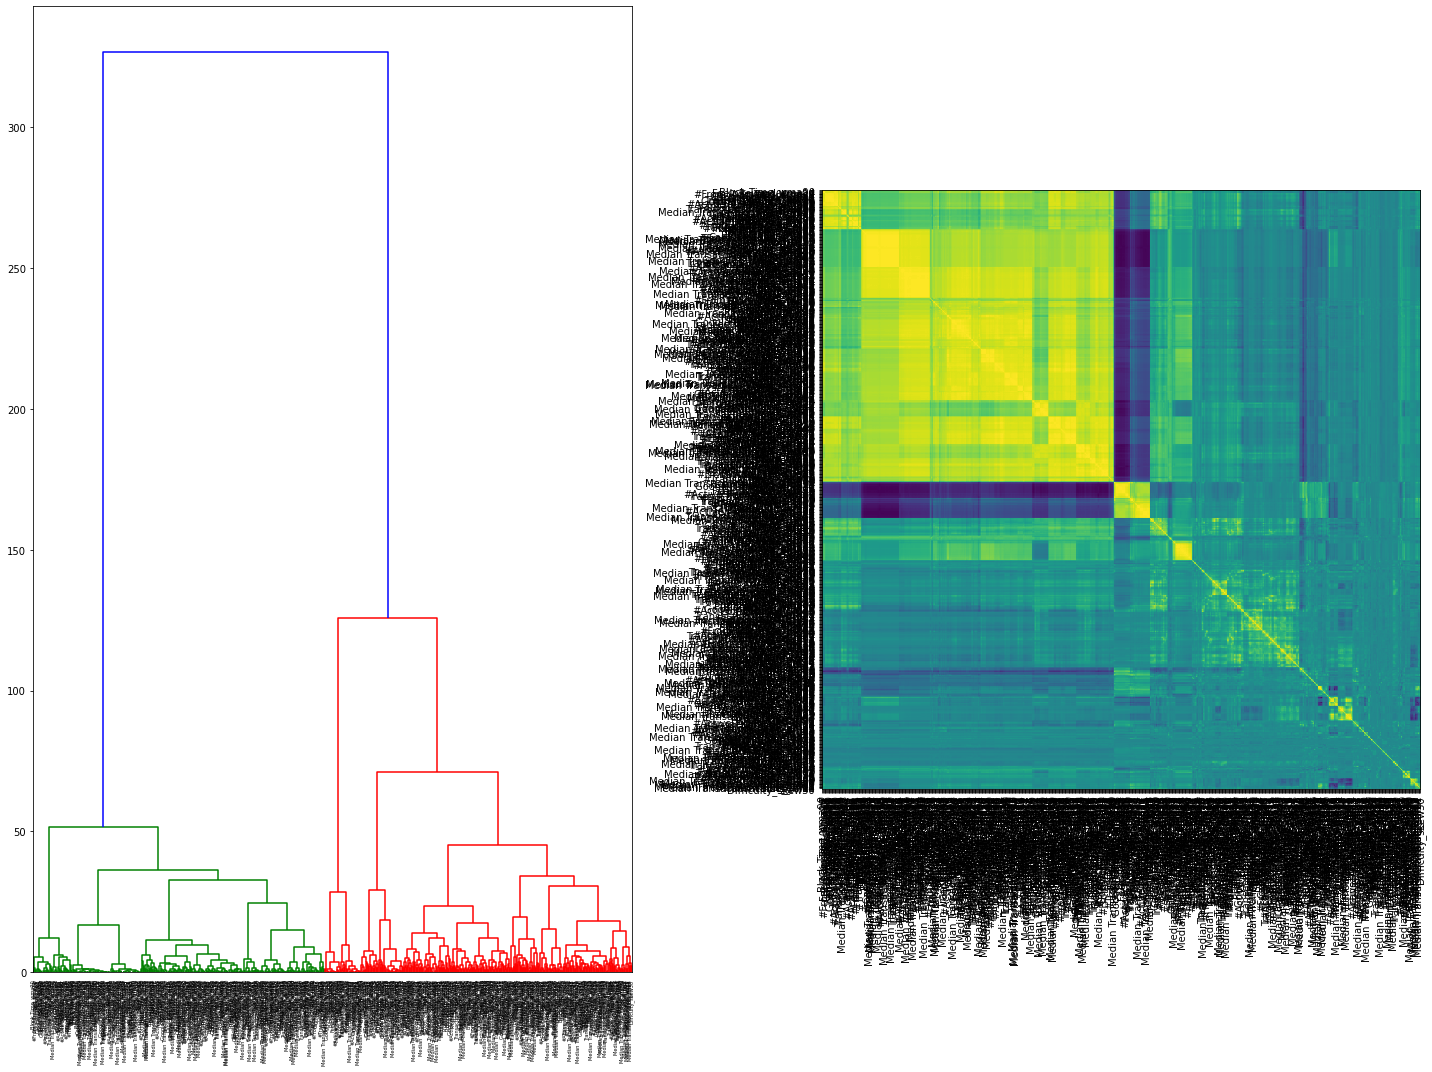

In [173]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

feature_perm = df_perm
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, ax=ax1, leaf_rotation=90, labels=feature_perm.index.values.tolist())
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

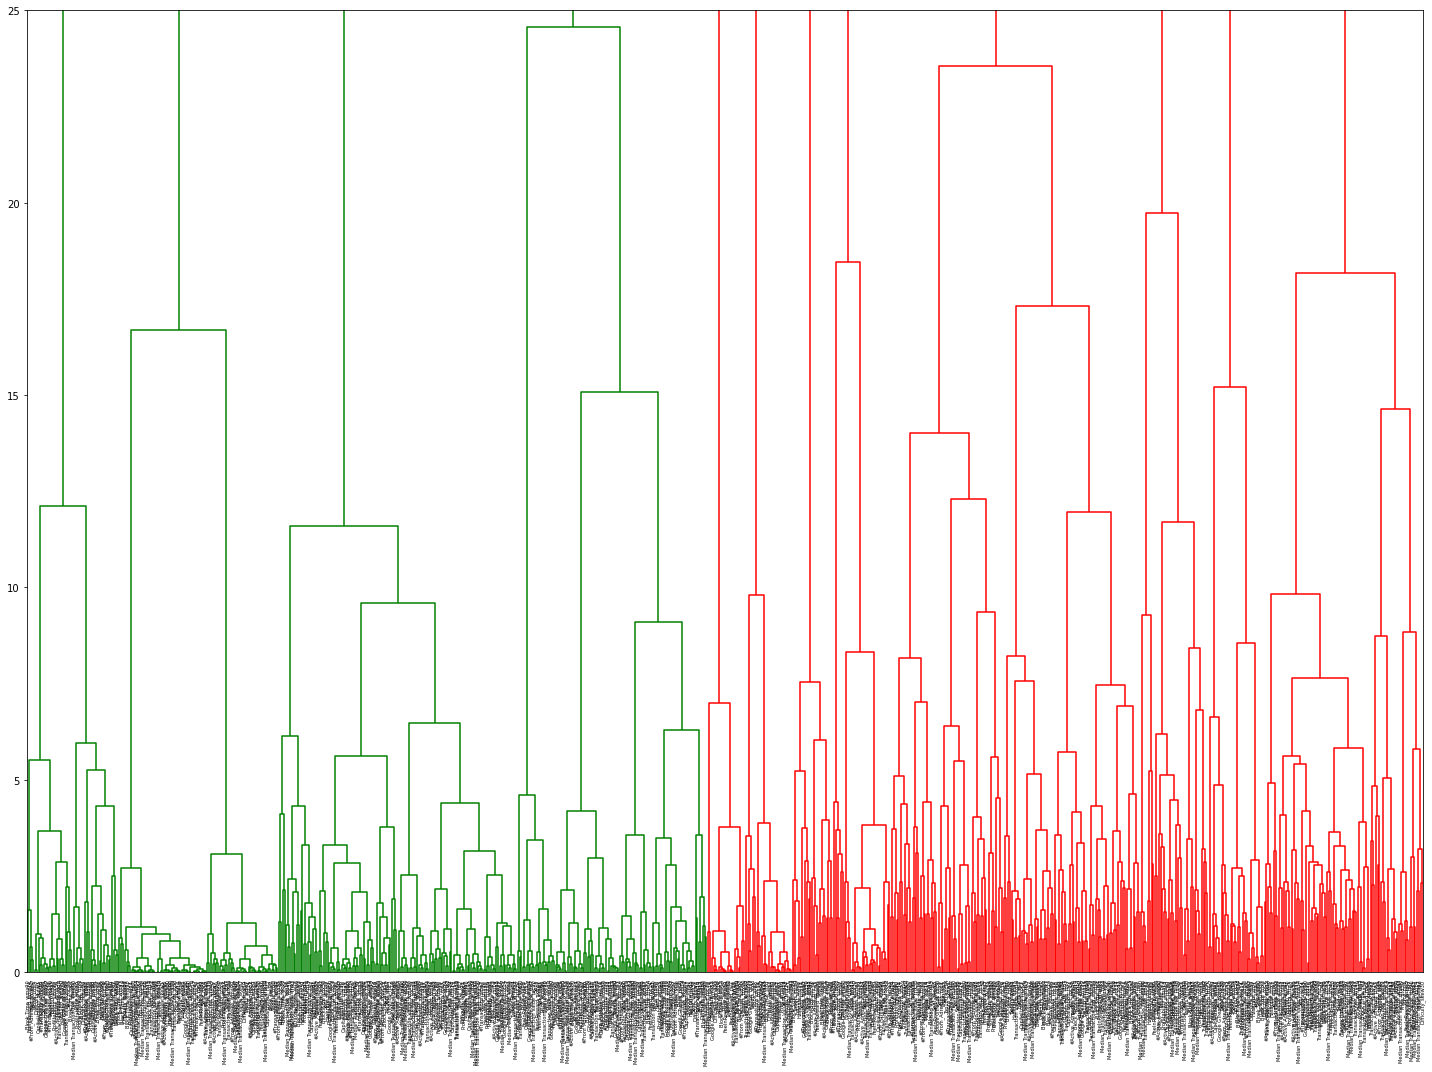

In [186]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 15))

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, ax=ax1, leaf_rotation=90, labels=feature_perm.index.values.tolist())
dendro_idx = np.arange(0, len(dendro['ivl']))

ax1.set_ylim(0,25)

fig.tight_layout()
plt.show()

Next, we manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and choose a feature from each cluster to keep, select those features from our dataset, and train a new random forest. The test accuracy of the new random forest did not change much compared to the random forest trained on the complete dataset.

In [167]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(corr_linkage, 25, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [168]:
selected_features 

[0, 1, 2, 5, 8, 14, 16, 17, 208, 217, 221, 269]

In [169]:
X.iloc[:,selected_features]

,#Active_Adresses,Block Size,Block Time,Transaction Value,Hashrate,Profiltability,Top100,Tweets,#Active_Adresses_rsi3,Hashrate_rsi3,Difficulty_rsi3,Price_rsi30
0,114998.0,187402.0,8.727,2500.0,3.221646e+17,4.049,21.241,18681.0,4.741515,4.935679,100.000000,48.692147
1,184462.0,265055.0,8.727,2878.0,3.302051e+17,3.938,21.197,9385.0,4.741515,4.935679,100.000000,48.692147
2,216194.0,295066.0,8.889,3052.0,3.337177e+17,3.695,21.127,8342.5,4.741515,4.935679,100.000000,48.692147
3,209509.0,282161.0,8.372,3646.0,3.311977e+17,3.586,21.157,7300.0,88.614020,70.125354,100.000000,48.692147
4,208147.0,360878.0,9.231,3222.0,3.350929e+17,3.180,21.155,23092.0,85.634236,82.350414,100.000000,48.692147
...,...,...,...,...,...,...,...,...,...,...,...,...
2304,931624.0,893218.0,10.667,368625.0,1.640463e+20,0.339,14.601,132963.0,53.498219,78.305479,99.999996,43.994895
2305,911731.0,880543.0,9.931,275845.0,1.625112e+20,0.331,14.611,86049.0,49.996330,74.697419,99.999996,44.271756
2306,849115.0,884132.0,10.213,337302.0,1.711981e+20,0.289,14.694,81258.0,38.192615,81.811273,99.999996,43.766356
2307,791356.0,893442.0,12.632,474291.0,1.582209e+20,0.295,14.685,110552.0,28.788381,50.190593,99.999996,48.598038


# Fusion des variables retenues

On fusionne les variables retenues par les deux méthodes :

# Autre

In [ ]:
features_list=[]
indicateurs_techniques=['sma','ema','wma','trix', 'std','skew','rsi','roc']
periode=['3','7','14','30','90']

for indicateur in indicateurs_techniques:
    for i in periode:
      print("%s%s" %(indicateur, i))
      filtre = str(indicateur) + str(i) + "$"

      X = df_data.filter(regex=filtre,axis=1)
      X = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(X)
      X = pd.DataFrame(X)
      X.columns = df_data.filter(regex=filtre,axis=1).columns

      rf1 = RandomForestRegressor(random_state=7,n_jobs=-1)
      rfecv = RFECV(rf1,step=0.9,min_features_to_select=1,verbose=1,cv=5,scoring='neg_mean_absolute_error', n_jobs=1)
      rfecv.fit(X,tf.squeeze(np.asarray(y),1))

      if rfecv.n_features_ > 1:
        rf1.fit(X,tf.squeeze(np.asarray(y),1))
        maximp = rf1.feature_importances_.max()
        for x in range(len(rf1.feature_importances_)):
          if maximp==rf1.feature_importances_[x]:
            new_features = X.columns[x]
      else:
        mask = rfecv.get_support()
        new_features = X.columns[mask]
      features_list.append(str(new_features))
      print(filtre+ ': ' + new_features)

In [ ]:
features_list

In [ ]:
l1=[]

for j in range(len(features_list)):
    result1 = re.search("'(.*)'],", features_list[j])
    if result1!=None:
        l1.append(result1.group(1))
        
for i in range(len(features_list)):
    result2 = re.search('.*',features_list[i])
    if len(result2.group(0))<33:
        l1.append(result2.group(0))

In [ ]:
l1.sort()
l1

In [ ]:
df_data_reduit=df_data[l1]
df_data_reduit.head()

Suppresion des valeurs non numériques :

In [ ]:
df_data_reduit = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(df_data_reduit)
df_data_reduit = pd.DataFrame(X)
df_data_reduit.columns = df_data_reduit.columns
df_data_reduit

# Identifications des variables réstantes collinéraires 

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function for removing features with high vif
def drop_high_vif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

#function for listing vif values
def vif_values(X):
    add_constant(X)
    df=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return df


In [ ]:
df_data_reduit = drop_high_vif(df_data_reduit,thresh=5)
df_data_reduit

In [ ]:
vif_values(df_data_reduit)

In [ ]:
Raw=drop_high_vif(X_raw,thresh=10)

In [ ]:
vif_values(Raw)

In [ ]:
Raw.insert(0,'Dates',df_data['Dates'])
df_data_reduit.insert(0,'Dates',df_data['Dates'])

In [ ]:
df_merged=Raw.merge(df_data_reduit,how='outer')
df_merged.drop_duplicates()

In [ ]:
df_merged.drop(columns='Dates',inplace=True)

In [ ]:
df_data_reduit=drop_high_vif(df_merged,thresh=10)
df_data_reduit

In [ ]:
vif_values(df_data_reduit)

In [ ]:
rf_final=RandomForestRegressor(random_state=7,n_jobs=-1)
rf_final.fit(df_data_reduit,tf.squeeze(np.asarray(y),1))

In [ ]:
# function for creating a feature importance dataframe
def feature_importance(column_names, importances):
    df = pd.DataFrame({'feature': column_names, 'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

In [ ]:
# plotting a feature importance dataframe (horizontal barchart)
def plot_feature_importance(imp_df, title):
    # figure size in inches
    plt.rcParams['figure.figsize'] = 11.7,8.27
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, color = 'royalblue').set_title(title, fontsize = 20)

In [ ]:
imp_feat=feature_importance(df_data_reduit.columns,rf_final.feature_importances_)
plot_feature_importance(imp_feat,'feature importance')

In [ ]:
imp_feat[imp_feat['feature_importance']>0]

In [ ]:
selected = imp_feat[imp_feat['feature_importance']>0]
selected

In [ ]:
selected.feature_importance.sum()

In [ ]:
df_data_reduit_high = df_data_reduit[np.asarray(selected.feature)]
df_data_reduit_high.sort_index(axis=1,inplace=True)
df_data_reduit_high['Price'] = np.ravel(y)
df_data_reduit_high = df_data_reduit_high[df_data_reduit_high['Price']!=1]
df_data_reduit_high

In [ ]:
corr = df_data_reduit_high.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [ ]:
from sklearn.ensemble import IsolationForest

anomalies=IsolationForest(contamination=0.1)

price=df_data_reduit_high['Price']
price=price.values
price=np.reshape(price,(-1,1))
anomalies.fit(price)

pred=anomalies.predict(price)

df_data_reduit_high['Anomalies'] = pred
df_data_reduit_high['Anomalies'] = df_data_reduit_high['Anomalies'].apply(lambda x: 1 if (x==-1) else 0)

# Affiche les informations sur les anomalies
print(df_data_reduit_high['Anomalies'].value_counts())

In [ ]:
import plotly.express as px

# Affiche la série

fig = px.line(x=df_data_reduit_high.index,y=df_data_reduit_high['Price'],title="Evolution du prix du BTC")
fig.add_trace(px.scatter(x=df_data_reduit_high.index,y=df_data_reduit_high['Anomalies']*df_data_reduit_high['Price'],color=df_data_reduit_high['Anomalies'].astype(np.bool)).data[0])

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

In [ ]:
#df_data_reduit_high.reset_index(drop=True,inplace=True)
df_data_reduit_high.drop(columns=['Anomalies'],inplace=True)

In [ ]:
df_data_reduit_high.insert(0,'Dates',df_data['Dates'])
df_data_reduit_high.set_index(df_data_reduit_high['Dates'])
df_data_reduit_high

In [ ]:
df_data_reduit_high.columns

In [ ]:
df_data_reduit_high.to_csv('reg_1d.csv')